# Food CNN

In [18]:
import tensorflow as tf
import glob

In [19]:
import pandas as pd 
import os
import numpy as np 
import cv2
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import regularizers, utils

import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data and Augment

In [29]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.1,)

crop_train_generator=datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128),
    subset='training')


crop_val_generator=datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128),
    
    subset='validation')

Found 10562 images belonging to 100 classes.
Found 1126 images belonging to 100 classes.


## Create Food Classifier

Use transfer learning with InceptionV3 as the base model

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


from tensorflow.keras import models
from tensorflow.keras.layers import Input
import tensorflow as tf

In [36]:
optimizer = Adam(lr = .001)

inception = InceptionResNetV2(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy', 'top_k_categorical_accuracy'])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_408 (BatchN (None, None, None, 3 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, None, None, 3 0           batch_normalization_408[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_583 (Conv2D)             (None, None, None, 2 129024      activation_582[0][0]             
__________________________________________________________________________________________________
batch_normalization_585 (BatchN (None, None, None, 2 672         conv2d_583[0][0]                 
__________________________________________________________________________________________________
activation_583 (Activation)     (None, None, None, 2 0           batch_normalization_585[0][0]    
__________________________________________________________________________________________________
conv2d_581 (Conv2D)             (None, None, None, 1 399360      block8_3_ac[0][0]                
__________________________________________________________________________________________________
conv2d_584 (Conv2D)             (None, None, None, 2 172032      activation_583[0][0]             
__________

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Train Model

In [37]:
history1 = model.fit(crop_train_generator, validation_data= crop_val_generator, epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
331/331 [==============================] - 97s 262ms/step - loss: 4.3318 - accuracy: 0.3140 - top_k_categorical_accuracy: 0.5752 - val_loss: 3.9838 - val_accuracy: 0.3464 - val_top_k_categorical_accuracy: 0.6234
Epoch 2/50
331/331 [==============================] - 91s 275ms/step - loss: 3.0365 - accuracy: 0.4246 - top_k_categorical_accuracy: 0.7212 - val_loss: 3.0653 - val_accuracy: 0.4103 - val_top_k_categorical_accuracy: 0.6927
Epoch 3/50
331/331 [==============================] - 87s 263ms/step - loss: 2.5603 - accuracy: 0.4717 - top_k_categorical_accuracy: 0.7664 - val_loss: 2.8778 - val_accuracy: 0.4254 - val_top_k_categorical_accuracy: 0.7025
Epoch 4/50
331/331 [==============================] - 86s 259ms/step - loss: 2.3617 - accuracy: 0.4967 - top_k_categorical_accuracy: 0.7903 - val_loss: 2.9231 - val_accuracy: 0.4085 - val_top_k_categorical_accuracy: 0.6909
Epoch 5/50
331/331 [==============================] - 87s 262ms/step - loss: 2.2488 - accuracy: 0.5087 - top

Epoch 37/50
331/331 [==============================] - 87s 264ms/step - loss: 1.1630 - accuracy: 0.7407 - top_k_categorical_accuracy: 0.9450 - val_loss: 2.3779 - val_accuracy: 0.5098 - val_top_k_categorical_accuracy: 0.7655
Epoch 38/50
331/331 [==============================] - 88s 266ms/step - loss: 1.1430 - accuracy: 0.7465 - top_k_categorical_accuracy: 0.9456 - val_loss: 2.2642 - val_accuracy: 0.5258 - val_top_k_categorical_accuracy: 0.7815
Epoch 39/50
331/331 [==============================] - 87s 263ms/step - loss: 1.1314 - accuracy: 0.7507 - top_k_categorical_accuracy: 0.9494 - val_loss: 2.3089 - val_accuracy: 0.5320 - val_top_k_categorical_accuracy: 0.7762
Epoch 40/50
331/331 [==============================] - 88s 267ms/step - loss: 1.1189 - accuracy: 0.7508 - top_k_categorical_accuracy: 0.9478 - val_loss: 2.3147 - val_accuracy: 0.5337 - val_top_k_categorical_accuracy: 0.7691
Epoch 41/50
331/331 [==============================] - 88s 264ms/step - loss: 1.1374 - accuracy: 0.7455 

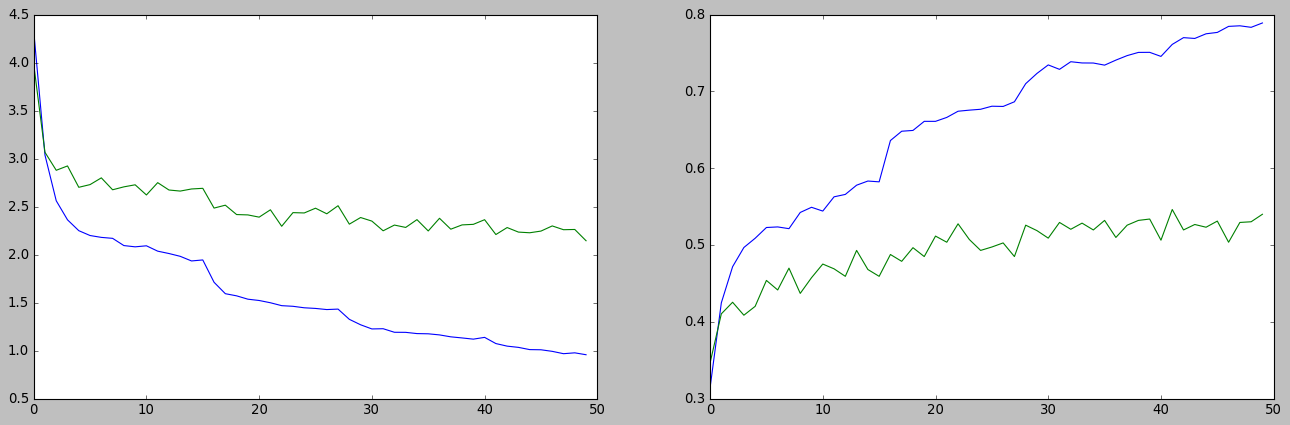

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history1.history['loss'])
axes[0].plot(history1.history['val_loss'])
axes[1].plot(history1.history['accuracy'])
axes[1].plot(history1.history['val_accuracy'])

In [46]:
history2 = model.fit(crop_train_generator, validation_data= crop_val_generator,epochs=50, verbose=True)

Epoch 1/50
331/331 [==============================] - 89s 269ms/step - loss: 0.9568 - accuracy: 0.7855 - top_k_categorical_accuracy: 0.9637 - val_loss: 2.1623 - val_accuracy: 0.5355 - val_top_k_categorical_accuracy: 0.7984
Epoch 2/50
331/331 [==============================] - 103s 311ms/step - loss: 0.9566 - accuracy: 0.7902 - top_k_categorical_accuracy: 0.9635 - val_loss: 2.1832 - val_accuracy: 0.5471 - val_top_k_categorical_accuracy: 0.8073
Epoch 3/50
331/331 [==============================] - 94s 282ms/step - loss: 0.9680 - accuracy: 0.7901 - top_k_categorical_accuracy: 0.9607 - val_loss: 2.2476 - val_accuracy: 0.5266 - val_top_k_categorical_accuracy: 0.7744
Epoch 4/50
331/331 [==============================] - 87s 264ms/step - loss: 0.9407 - accuracy: 0.7922 - top_k_categorical_accuracy: 0.9642 - val_loss: 2.1608 - val_accuracy: 0.5560 - val_top_k_categorical_accuracy: 0.7869
Epoch 5/50
331/331 [==============================] - 91s 274ms/step - loss: 0.9505 - accuracy: 0.7908 - to

Epoch 38/50
331/331 [==============================] - 83s 250ms/step - loss: 0.8485 - accuracy: 0.8126 - top_k_categorical_accuracy: 0.9696 - val_loss: 2.1559 - val_accuracy: 0.5533 - val_top_k_categorical_accuracy: 0.7966
Epoch 39/50
331/331 [==============================] - 81s 245ms/step - loss: 0.8331 - accuracy: 0.8153 - top_k_categorical_accuracy: 0.9713 - val_loss: 2.1582 - val_accuracy: 0.5453 - val_top_k_categorical_accuracy: 0.7957
Epoch 40/50
331/331 [==============================] - 82s 247ms/step - loss: 0.8542 - accuracy: 0.8030 - top_k_categorical_accuracy: 0.9709 - val_loss: 2.1283 - val_accuracy: 0.5551 - val_top_k_categorical_accuracy: 0.7975
Epoch 41/50
331/331 [==============================] - 81s 245ms/step - loss: 0.8356 - accuracy: 0.8168 - top_k_categorical_accuracy: 0.9693 - val_loss: 2.1764 - val_accuracy: 0.5533 - val_top_k_categorical_accuracy: 0.7922
Epoch 42/50
331/331 [==============================] - 81s 245ms/step - loss: 0.8526 - accuracy: 0.8077 

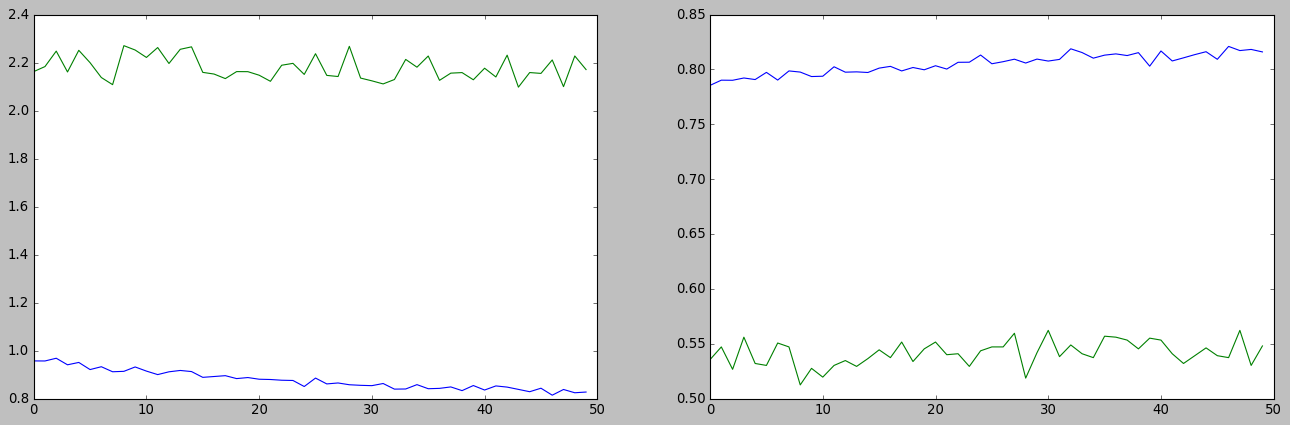

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history2.history['loss'])
axes[0].plot(history2.history['val_loss'])
axes[1].plot(history2.history['accuracy'])
axes[1].plot(history2.history['val_accuracy'])

In [48]:
history3 =model.fit(crop_train_generator, validation_data= crop_val_generator, epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
331/331 [==============================] - 97s 293ms/step - loss: 0.8275 - accuracy: 0.8122 - top_k_categorical_accuracy: 0.9728 - val_loss: 2.2381 - val_accuracy: 0.5311 - val_top_k_categorical_accuracy: 0.8002
Epoch 2/50
331/331 [==============================] - 97s 293ms/step - loss: 0.8246 - accuracy: 0.8171 - top_k_categorical_accuracy: 0.9724 - val_loss: 2.1610 - val_accuracy: 0.5409 - val_top_k_categorical_accuracy: 0.7886
Epoch 3/50
331/331 [==============================] - 99s 297ms/step - loss: 0.8248 - accuracy: 0.8165 - top_k_categorical_accuracy: 0.9696 - val_loss: 2.2335 - val_accuracy: 0.5258 - val_top_k_categorical_accuracy: 0.7780
Epoch 4/50
331/331 [==============================] - 99s 299ms/step - loss: 0.8215 - accuracy: 0.8205 - top_k_categorical_accuracy: 0.9706 - val_loss: 2.0918 - val_accuracy: 0.5488 - val_top_k_categorical_accuracy: 0.7975
Epoch 5/50
331/331 [==============================] - 100s 302ms/step - loss: 0.8169 - accuracy: 0.8174 - to

331/331 [==============================] - 82s 247ms/step - loss: 0.7516 - accuracy: 0.8372 - top_k_categorical_accuracy: 0.9776 - val_loss: 2.1222 - val_accuracy: 0.5373 - val_top_k_categorical_accuracy: 0.8055
Epoch 37/50
331/331 [==============================] - 82s 247ms/step - loss: 0.7617 - accuracy: 0.8314 - top_k_categorical_accuracy: 0.9763 - val_loss: 2.0917 - val_accuracy: 0.5560 - val_top_k_categorical_accuracy: 0.7948
Epoch 38/50
331/331 [==============================] - 82s 248ms/step - loss: 0.7802 - accuracy: 0.8259 - top_k_categorical_accuracy: 0.9759 - val_loss: 2.1187 - val_accuracy: 0.5311 - val_top_k_categorical_accuracy: 0.7975
Restoring model weights from the end of the best epoch.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 00038: early stopping


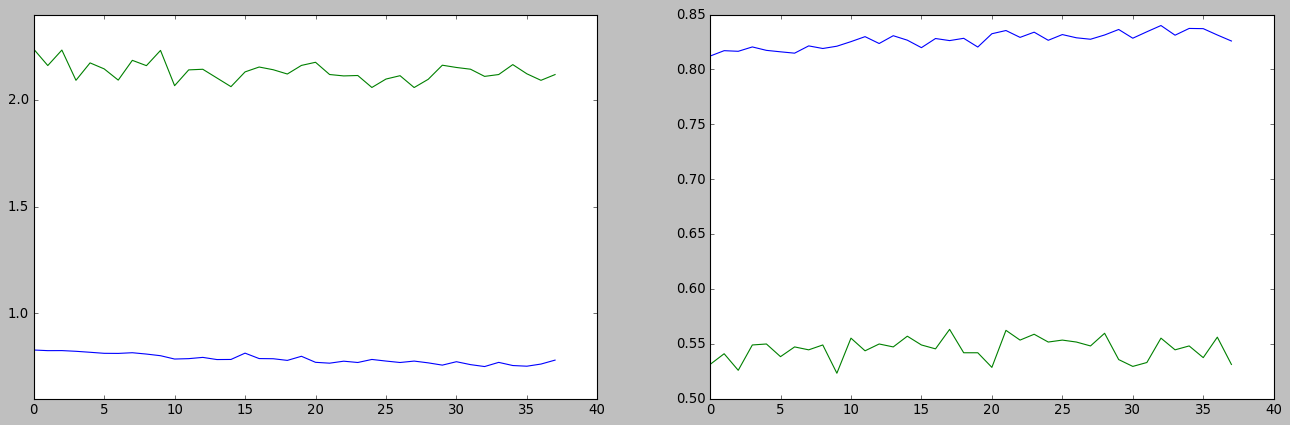

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history3.history['loss'])
axes[0].plot(history3.history['val_loss'])
axes[1].plot(history3.history['accuracy'])
axes[1].plot(history3.history['val_accuracy'])

## Test on raw dataset without augmentation

In [79]:
no_augment_datagen=ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

train_crop_no_augment = no_augment_datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,128))

test_crop_no_augment = no_augment_datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/test_crop",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,128),
    subset='training')

Found 11688 images belonging to 100 classes.
Found 2922 images belonging to 100 classes.


In [66]:
model.evaluate(train_crop_no_augment)

366/366 [==============================] - 40s 108ms/step - loss: 0.5924 - accuracy: 0.9019 - top_k_categorical_accuracy: 0.9801


[0.5923793315887451, 0.9018651843070984, 0.9800650477409363]

In [67]:
model.evaluate(test_crop_no_augment)

92/92 [==============================] - 11s 114ms/step - loss: 1.6399 - accuracy: 0.6400 - top_k_categorical_accuracy: 0.8734


[1.6399325132369995, 0.6399726271629333, 0.8733744025230408]

In [147]:
model.save('uec100')

INFO:tensorflow:Assets written to: uec100\assets


## Accuracy measures

In [82]:
ytrue =test_crop_no_augment.classes

In [83]:
ypred = model.predict(test_crop_no_augment)

In [84]:
ypred_label = [np.argmax(pred) for pred in ypred]

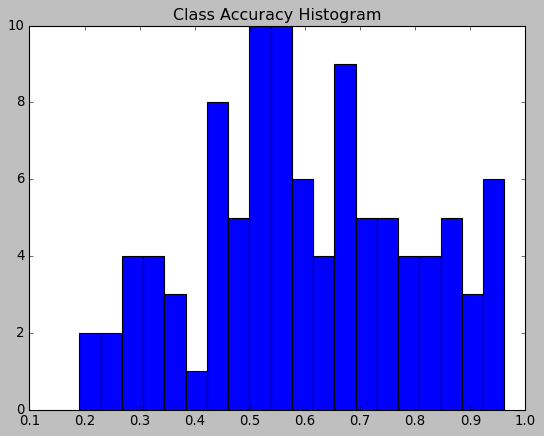

In [86]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
matrix = confusion_matrix(ytrue, ypred_label)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
plt.style.use('classic')
plt.title('Class Accuracy Histogram')
p = plt.hist(class_accuracies, bins=20)


In [87]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(100):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(ytrue))[:, i], ypred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\reonh\AppData\Local\Temp/ipykernel_33176/4213337631.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


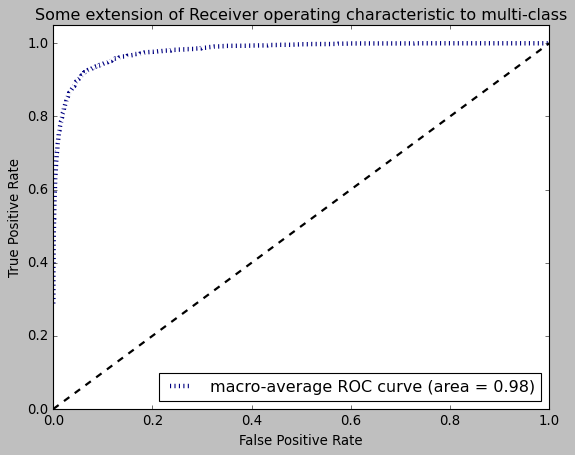

In [88]:
from scipy import interp
from itertools import cycle
lw = 2
n_classes = 100


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

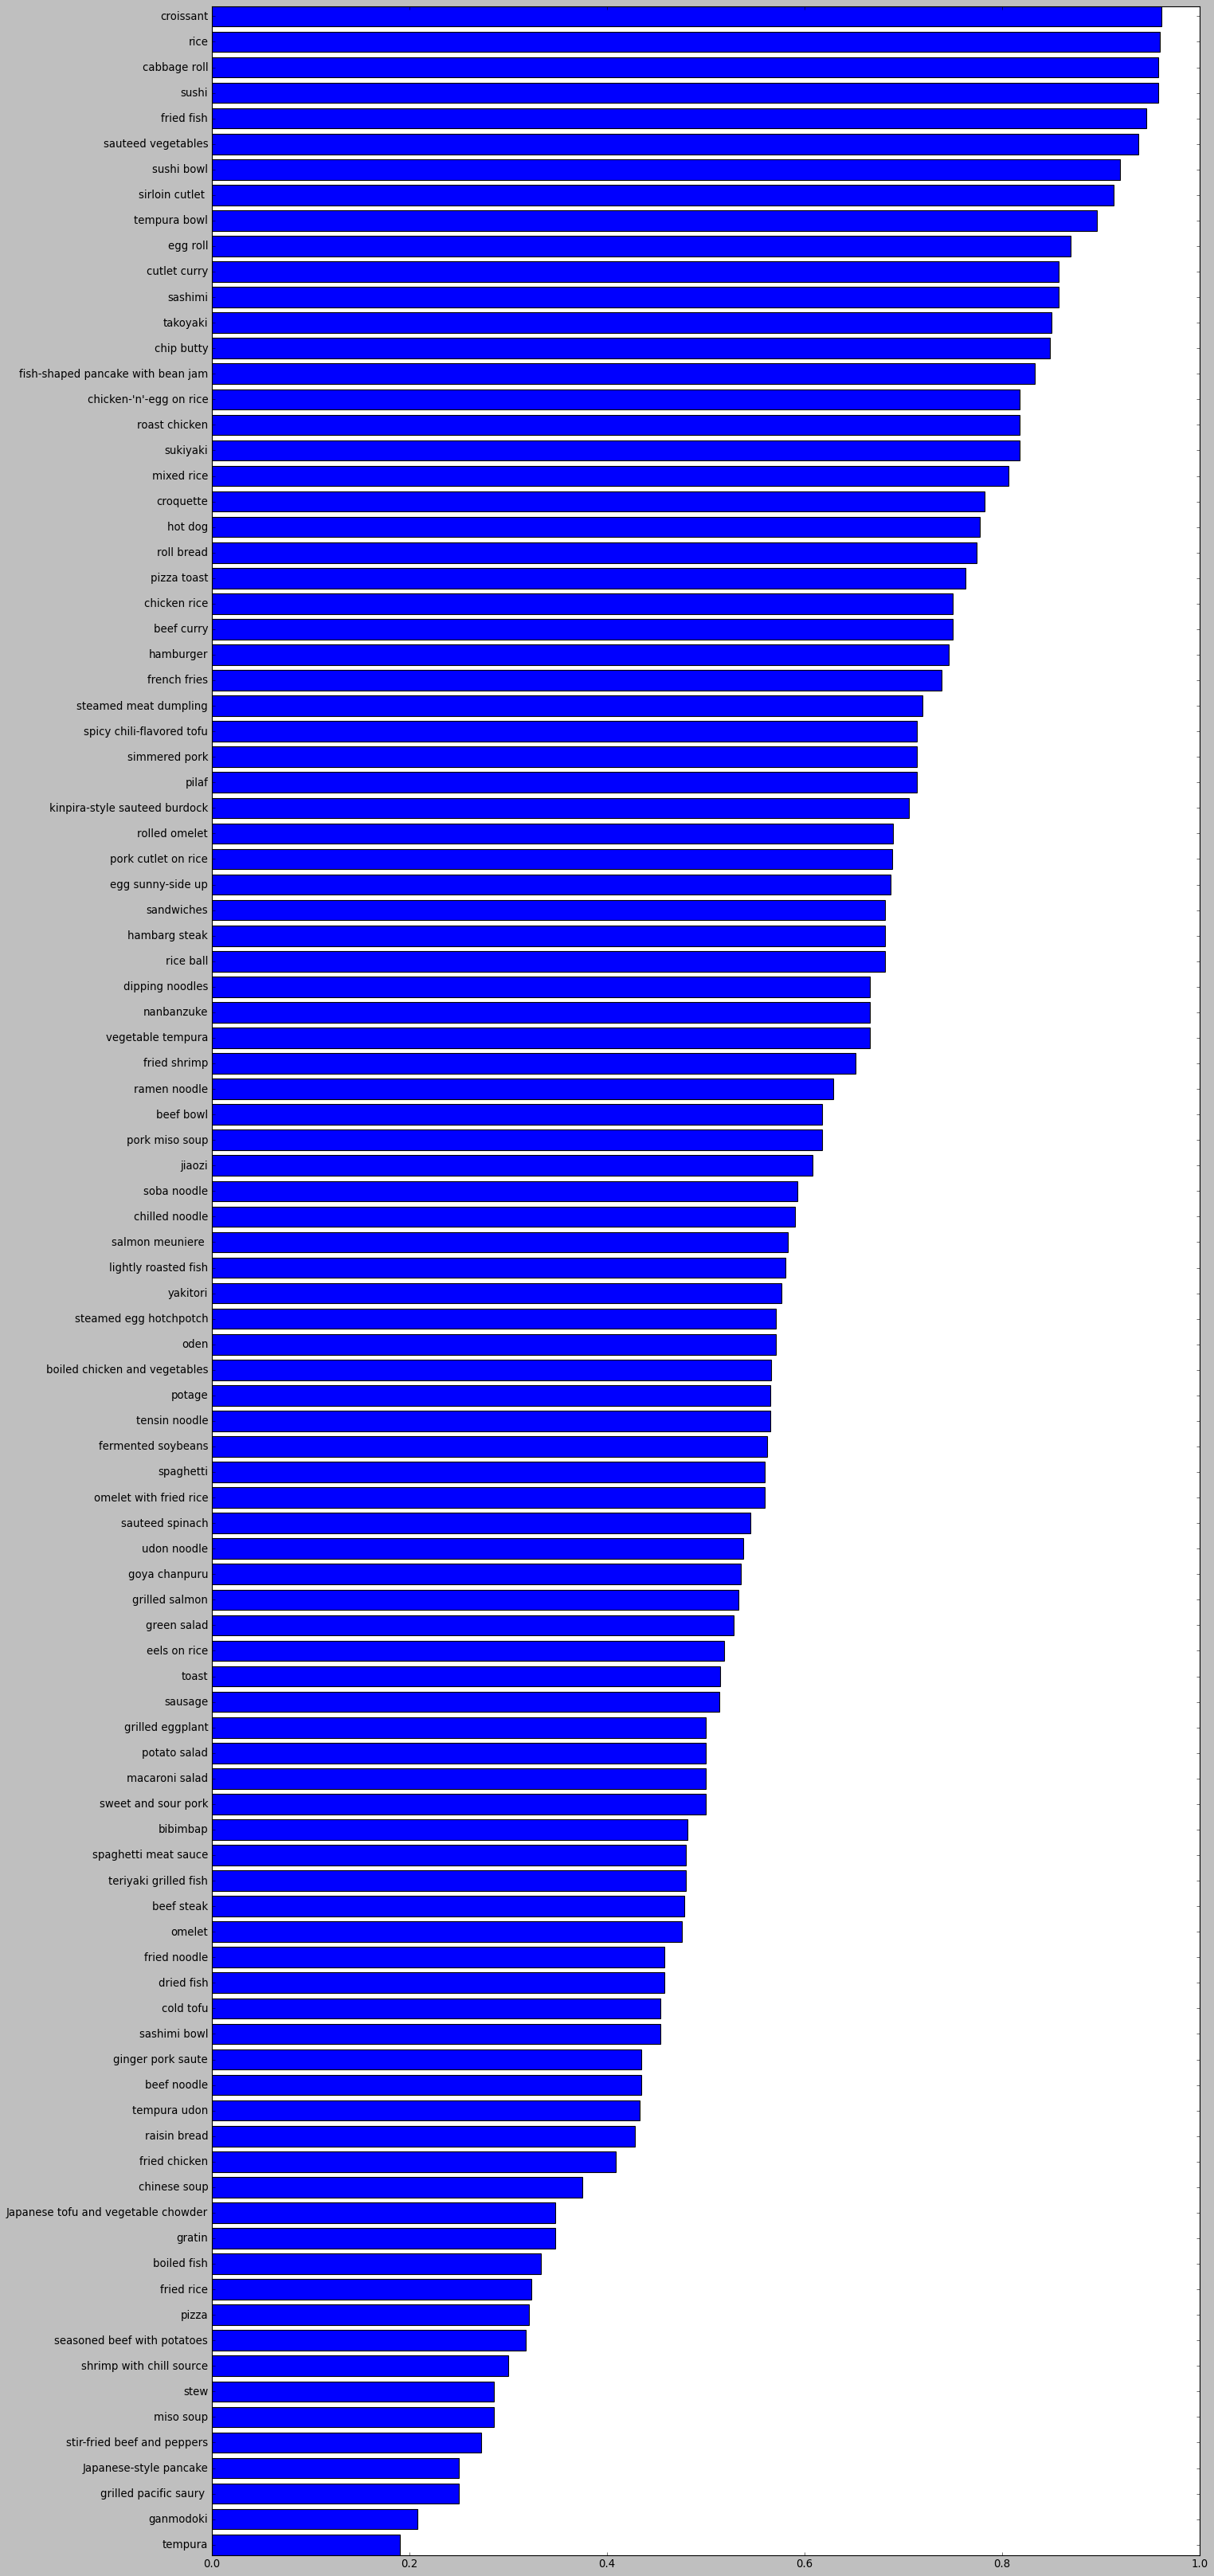

In [97]:
class_labels = pd.read_csv('./UECFOOD100_CROP/category.txt', sep='\t')
acc = class_labels.join(pd.DataFrame(class_accuracies)).rename(columns={0:'class_accuracy'}).sort_values('class_accuracy')
plt.figure(figsize=(20,50))
p = plt.barh(acc.name, acc.class_accuracy)

In [91]:
acc

,id,name,class_accuracy
53,54,tempura,0.190476
40,41,ganmodoki,0.208333
48,49,grilled pacific saury,0.250000
27,28,Japanese-style pancake,0.250000
72,73,stir-fried beef and peppers,0.272727
...,...,...,...
44,45,fried fish,0.945946
6,7,sushi,0.958333
65,66,cabbage roll,0.958333
0,1,rice,0.960000


## Try random images

In [444]:
class_labels.sort_values('id')

,id,name
0,1,rice
1,2,eels on rice
2,3,pilaf
3,4,chicken-'n'-egg on rice
4,5,pork cutlet on rice
...,...,...
95,96,dipping noodles
96,97,hot dog
97,98,french fries
98,99,mixed rice


In [100]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
text_labels = imagedata[['foodclass']].astype(str).drop_duplicates().set_index('foodclass').join(class_labels.astype(str).set_index('id'))
text_labels

,name
foodclass,
1,rice
10,tempura bowl
100,goya chanpuru
11,bibimbap
12,toast
...,...
95,pizza toast
96,dipping noodles
97,hot dog


name    fried rice
Name: 9, dtype: object


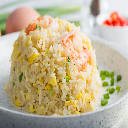

In [101]:
img =load_img('web_pics/friedrice.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    fish-shaped pancake with bean jam
Name: 78, dtype: object


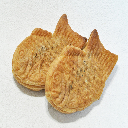

In [102]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    eels on rice
Name: 2, dtype: object


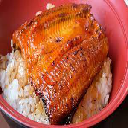

In [103]:
img =load_img('web_pics/unagi.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    sushi bowl
Name: 77, dtype: object


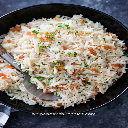

In [104]:
img =load_img('web_pics/pilaf.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    croissant
Name: 13, dtype: object


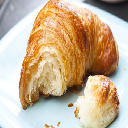

In [105]:
img = load_img('web_pics/crossaint.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

## Convert Classifier to Object Detector

In [106]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w,w))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [107]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.1):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = area

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [108]:
def detect_food(img):
    WIDTH = 128
    PYR_SCALE = 1.5
    WIN_STEP = 16
    ROI_SIZE = (128,128)
    INPUT_SIZE = (128, 128)
    rois = []
    locs = []
    (H, W) = img.shape[:2]
    pyramid = image_pyramid(img, minSize=(128,128))
    for image in pyramid:
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            
    import time
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs and print how long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    
    bbox_predictions = {}

    for i, p in enumerate(preds):
        # grab the prediction information for the current ROI
        predicted_label = np.argmax(p)

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if p[predicted_label] >= 0.995:

            # grab the bounding box associated with the prediction and
            # convert the coordinates
            box = locs[i]
            predicted_label_text = text_labels.iloc[predicted_label][0]

            L = bbox_predictions.get(predicted_label_text, [])
            L.append((box, p[predicted_label]))
            bbox_predictions[predicted_label_text] = L
    
    clone = img.copy()

    for item in bbox_predictions.keys():
        
        boxes = np.array([p[0] for p in bbox_predictions[item]])
        proba = np.array([p[1] for p in bbox_predictions[item]])
        boxes = non_max_suppression(boxes,proba)
        
        print('[FOOD DETECTED] ' +  item + ' ' + str(proba.max()))
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, item, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            break
            
    plt.imshow(np.clip(clone, a_max = 1, a_min=0))


[INFO] classifying ROIs...
[INFO] classifying ROIs took 4.77861 seconds
[FOOD DETECTED] miso soup 0.9991436
[FOOD DETECTED] dipping noodles 0.9972742
[FOOD DETECTED] rice 1.0


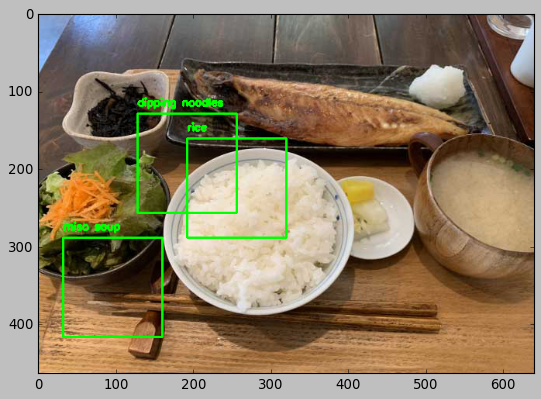

In [109]:
img = load_img('web_pics/jpfood.jpg')
img = img_to_array(img)/255
detect_food(img)

[INFO] classifying ROIs...
[INFO] classifying ROIs took 6.75785 seconds
[FOOD DETECTED] steamed egg hotchpotch 0.9998406
[FOOD DETECTED] miso soup 0.9978644
[FOOD DETECTED] rice 1.0


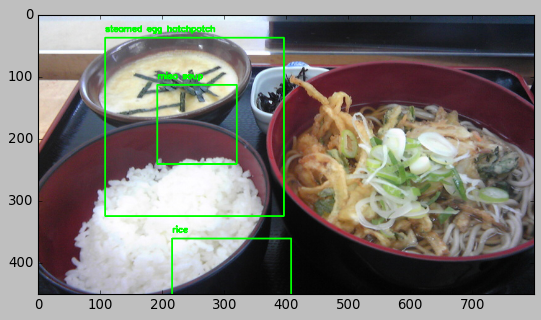

In [110]:
img = load_img('web_pics/setmeal.jpg')
img = img_to_array(img)/255
detect_food(img)

In [ ]:
food_dict = {'french fries': {'protein': 0, 'carb': 20, 'fat': 999}}

[INFO] classifying ROIs...
[INFO] classifying ROIs took 6.88099 seconds
[FOOD DETECTED] french fries 0.99998045
[FOOD DETECTED] hamburger 0.99997056


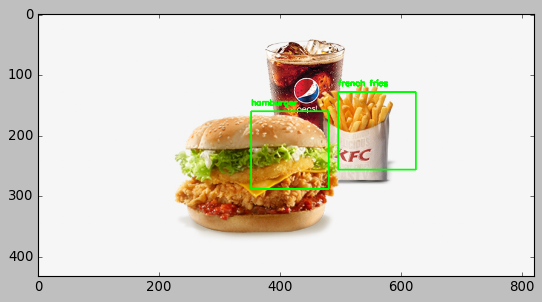

In [111]:
img = load_img('web_pics/fastfood_meal.jpg')
img = img_to_array(img)/255
detect_food(img)

[INFO] classifying ROIs...
[INFO] classifying ROIs took 2.58433 seconds
[FOOD DETECTED] croissant 1.0


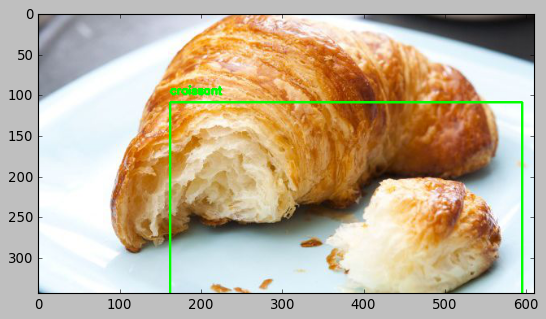

In [765]:
img = load_img('web_pics/crossaint.jpg')
img = img_to_array(img)/255
detect_food(img)